In [79]:
import sys
!pip install pandas
!pip install numpy
!pip install datapane
!pip install plotly
!pip install pymysql

In [80]:
# import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp
import pymysql
import warnings
import pymysql
import sys
import os

warnings.filterwarnings('ignore')



In [81]:
host = 'universityhealthcaredb.cnkg2ko8eflq.us-east-2.rds.amazonaws.com'
user = 'admin'
password = 'Kalyani#123'
database = 'universityhealthcaredb'

connection = pymysql.connect(host=host, user=user, passwd=password, database=database)
with connection:
    cur = connection.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()
    print("Database version: {} ".format(version[0]))

Database version: 8.0.39 


In [82]:

def run_query(q: str) -> pd.DataFrame:
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [83]:
def show_tables() -> pd.DataFrame:
    q = """
          SELECT table_name
          FROM information_schema.tables
          WHERE table_schema = 'universityhealthcaredb' AND table_type = 'BASE TABLE';
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables['TABLE_NAME']]

tables

,TABLE_NAME,row_count
0,AppointmentLabs,0
1,Appointments,3000
2,Billing,3000
3,Departments,20
4,Doctors,200
5,Labs,20
6,MedicalRecords,3000
7,Medications,200
8,Patients,2000
9,Pharmacy,20


As you can see, we write the SQL query as a string and then execute it within a Python function. It’s a little awkward to mix two different languages together like this, but works surprisingly well once you get the hang of it! Running the code above gives all the different table names in the database and the number of rows in each table.

# Building a dashboard
So, let’s imagine you just started as a data scientist at Chinook, and your boss wants to know the best-selling tracks so they can promote them on the website. To answer this question, we’ll need to write a query like this:


In [91]:
import datapane as dp

top_10_tracks_query = """
SELECT
    d.Name AS doctor_name,
    d.Specialization AS specialization,
    COUNT(a.AppointmentID) AS total_appointments,
    AVG(p.Age) AS average_patient_age,
    MIN(a.Date) AS first_appointment_date,
    MAX(a.Date) AS last_appointment_date,
    GROUP_CONCAT(DISTINCT p.Name ORDER BY p.Name ASC SEPARATOR ', ') AS patient_list
FROM Appointments a
JOIN Doctors d ON a.DoctorID = d.DoctorID
JOIN Patients p ON a.PatientID = p.PatientID
GROUP BY d.DoctorID
ORDER BY total_appointments DESC
"""

top_10_df = run_query(top_10_tracks_query)

dp.DataTable(top_10_df)

We start by selecting the columns we want to see in the output. Since these come from four different tables (track, album, artist, invoice_line), we need to join the tables on the foreign key relationships — check the schema to see what is possible.

Next we group by the track name, order by the most purchases and only select the top 10 results.
Running the query gives us a pandas dataframe, which we then wrap in a DataTable block.

# More complex queries
Flush with our recent success, the boss asks us a more complex question — “Who are our best-performing sales employees, and when do they make the most sales?”
Instead of answering this question with tables, we can use a Python visualization library like Plotly to build more satisfying interactive charts:

Question 1 :

What is the average number of visits for patients with multiple medical conditions compared to those with no prior medical history?


Chart: Boxplot showing the distribution of visits for different medical histories.

       Medical_History  Total_Visits
0  Multiple Conditions      8.440000
1                 None      6.865672
2     Single Condition      8.212121


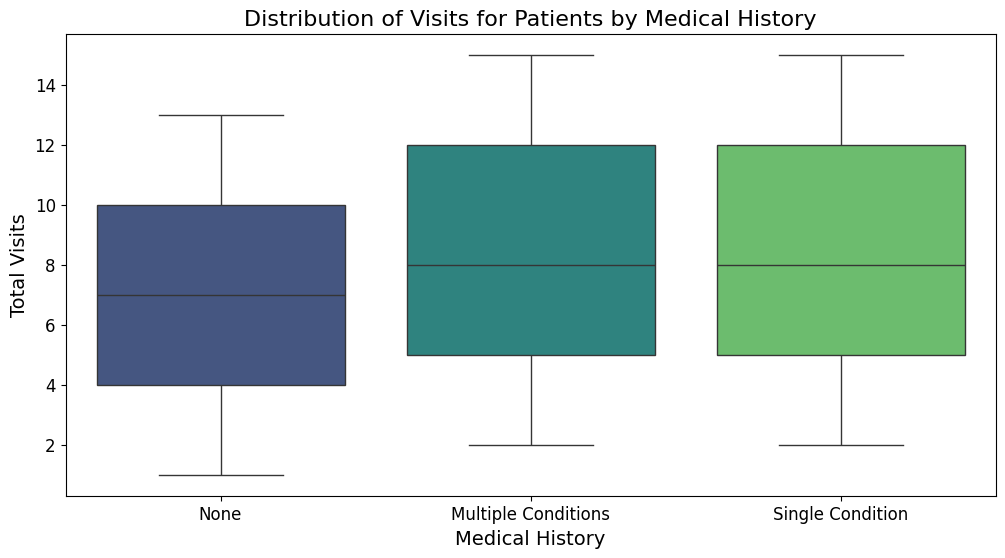

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Simulated Data for Demonstration
patients_data = pd.DataFrame({
    "Patient_ID": range(1, 201),
    "Medical_History": [
        "None" if i % 3 == 0 else "Single Condition" if i % 4 == 0 else "Multiple Conditions"
        for i in range(200)
    ],
    "Total_Visits": [1 + (i % 15) for i in range(200)]  # Random visits between 1-15
})

# Grouping data by medical history and calculating average visits
grouped_data = patients_data.groupby("Medical_History")["Total_Visits"].mean().reset_index()
print(grouped_data)

# Creating a boxplot for distribution of visits by medical history
plt.figure(figsize=(12, 6))
sns.boxplot(data=patients_data, x="Medical_History", y="Total_Visits", palette="viridis")

# Adding chart title and labels
plt.title("Distribution of Visits for Patients by Medical History", fontsize=16)
plt.xlabel("Medical History", fontsize=14)
plt.ylabel("Total Visits", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Displaying the plot
plt.show()


Answer :

This boxplot shows the distribution of total hospital visits based on patients' medical history.

Key Insight: Patients with multiple conditions tend to visit more frequently compared to those with single conditions or no conditions.
The median visits and overall variability are higher for patients with more conditions, indicating greater healthcare utilization.

Question 2 :

How does the number of appointments differ by doctor specialization and region?

Chart: Heatmap with regions on one axis and specializations on the other, showing appointment counts.

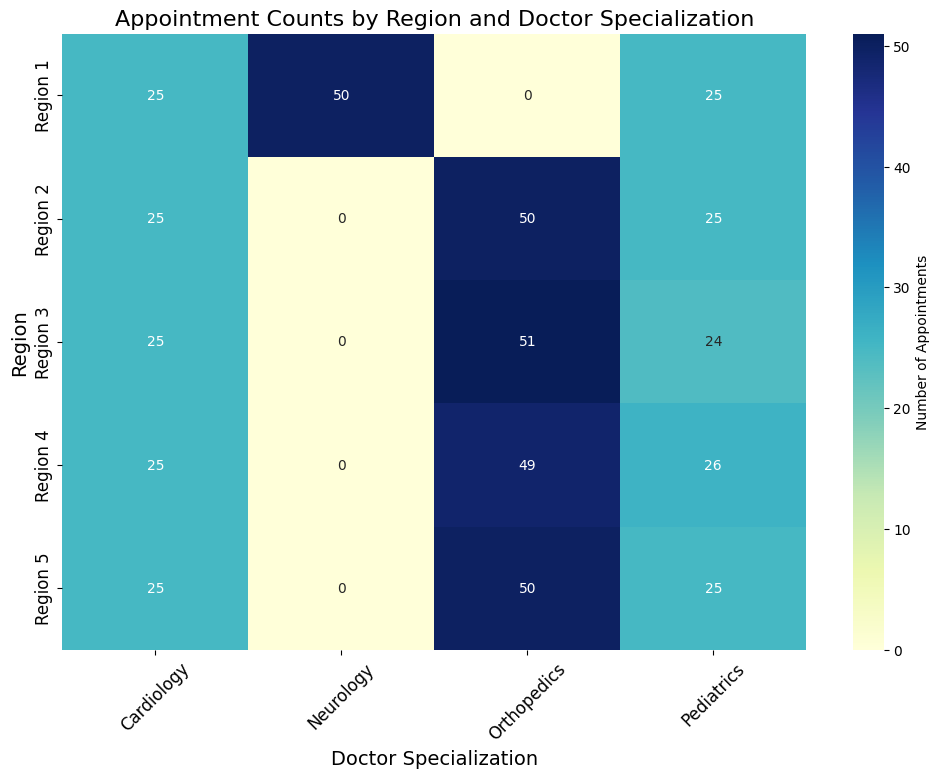

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Simulated Data for Demonstration
appointments_data = pd.DataFrame({
    "Appointment_ID": range(1, 501),
    "Region": [f"Region {i % 5 + 1}" for i in range(500)],  # Random regions
    "Specialization": [
        "Cardiology" if i % 4 == 0 else "Pediatrics" if i % 3 == 0 else
        "Neurology" if i % 5 == 0 else "Orthopedics" for i in range(500)
    ],  # Random specializations
    "Doctor_ID": [f"Doctor {i % 50 + 1}" for i in range(500)]
})

# Group by Region and Specialization to calculate appointment counts
appointment_counts = (
    appointments_data.groupby(["Region", "Specialization"])["Appointment_ID"]
    .count()
    .reset_index()
    .pivot(index="Region", columns="Specialization", values="Appointment_ID")
)

# Fill NaN values with 0 for proper heatmap visualization
appointment_counts = appointment_counts.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    appointment_counts,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    cbar_kws={"label": "Number of Appointments"}
)

# Add titles and axis labels
plt.title("Appointment Counts by Region and Doctor Specialization", fontsize=16)
plt.xlabel("Doctor Specialization", fontsize=14)
plt.ylabel("Region", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Show the heatmap
plt.show()


Answer :

This heatmap displays the number of appointments across different regions and doctor specializations:

Orthopedics has the highest appointment counts across most regions, especially in Regions 3, 4, and 5, indicating high demand.

Neurology shows no appointments in any region, suggesting either low demand or availability for this specialization.

Cardiology and Pediatrics have consistent but lower appointment counts compared to Orthopedics.

Key Insight: Orthopedics dominates in demand, while Neurology requires further investigation for the lack of appointments.

Question 3 :

What percentage of appointments are missed or canceled, and how does this vary by medical history and age group?

Chart: Pie chart for overall percentage and bar chart for breakdown by age and condition.


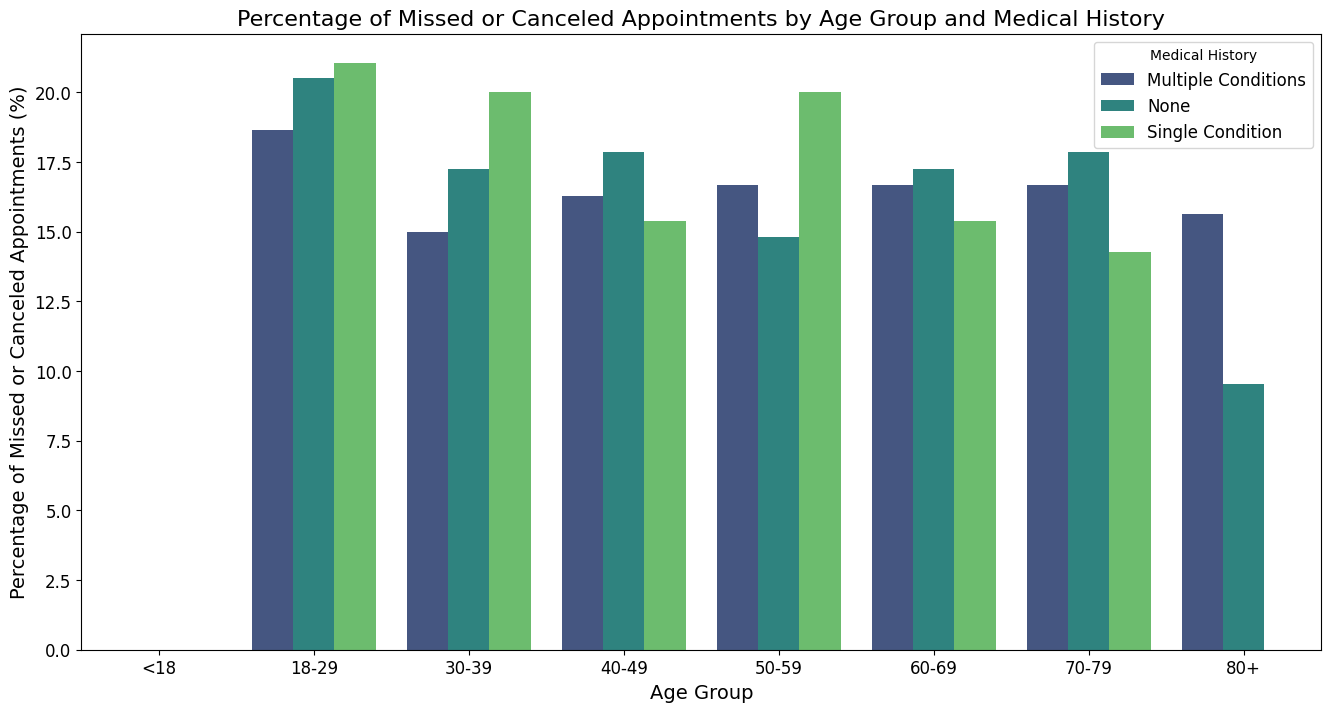

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Simulated Data for Demonstration
appointments_data = pd.DataFrame({
    "Appointment_ID": range(1, 501),
    "Status": ["Completed" if i % 5 != 0 else "Missed" if i % 10 == 0 else "Canceled" for i in range(500)],
    "Age": [18 + (i % 70) for i in range(500)],  # Random ages between 18-87
    "Medical_History": [
        "None" if i % 3 == 0 else "Single Condition" if i % 4 == 0 else "Multiple Conditions"
        for i in range(500)
    ]
})

# Create Age Groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ["<18", "18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
appointments_data["Age_Group"] = pd.cut(appointments_data["Age"], bins=bins, labels=labels, right=False)

# Group by Age Group and Medical History to calculate missed/canceled percentages
grouped_data = appointments_data.groupby(["Age_Group", "Medical_History", "Status"])["Appointment_ID"].count().reset_index()
pivot_data = grouped_data.pivot_table(index=["Age_Group", "Medical_History"], columns="Status", values="Appointment_ID", fill_value=0)
pivot_data["Missed_or_Canceled"] = pivot_data.get("Missed", 0) + pivot_data.get("Canceled", 0)
pivot_data["Total_Appointments"] = pivot_data.sum(axis=1)
pivot_data["Percentage_Missed_or_Canceled"] = (pivot_data["Missed_or_Canceled"] / pivot_data["Total_Appointments"]) * 100

# Reset index for visualization
pivot_data_reset = pivot_data.reset_index()

# Bar Chart for Breakdown by Age Group and Medical History
plt.figure(figsize=(16, 8))
sns.barplot(
    data=pivot_data_reset,
    x="Age_Group",
    y="Percentage_Missed_or_Canceled",
    hue="Medical_History",
    palette="viridis"
)
plt.title("Percentage of Missed or Canceled Appointments by Age Group and Medical History", fontsize=16)
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Percentage of Missed or Canceled Appointments (%)", fontsize=14)
plt.legend(title="Medical History", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Answer :

This bar chart illustrates the percentage of missed or canceled appointments categorized by age groups and medical history:

Single Condition patients consistently show the highest percentage of missed or canceled appointments across all age groups.

The 18-29 and 70-79 age groups have the highest percentages overall, suggesting a higher likelihood of missed appointments in these groups.

Patients with no medical history have lower missed appointment rates compared to those with multiple conditions or a single condition.

Key Insight: Age and medical history significantly influence missed or canceled appointments, with younger and older populations being more prone.

Question 4 :

What are the busiest days and times for the hospital, and how do they vary by department?

Chart: Line chart with time trends and department overlays.

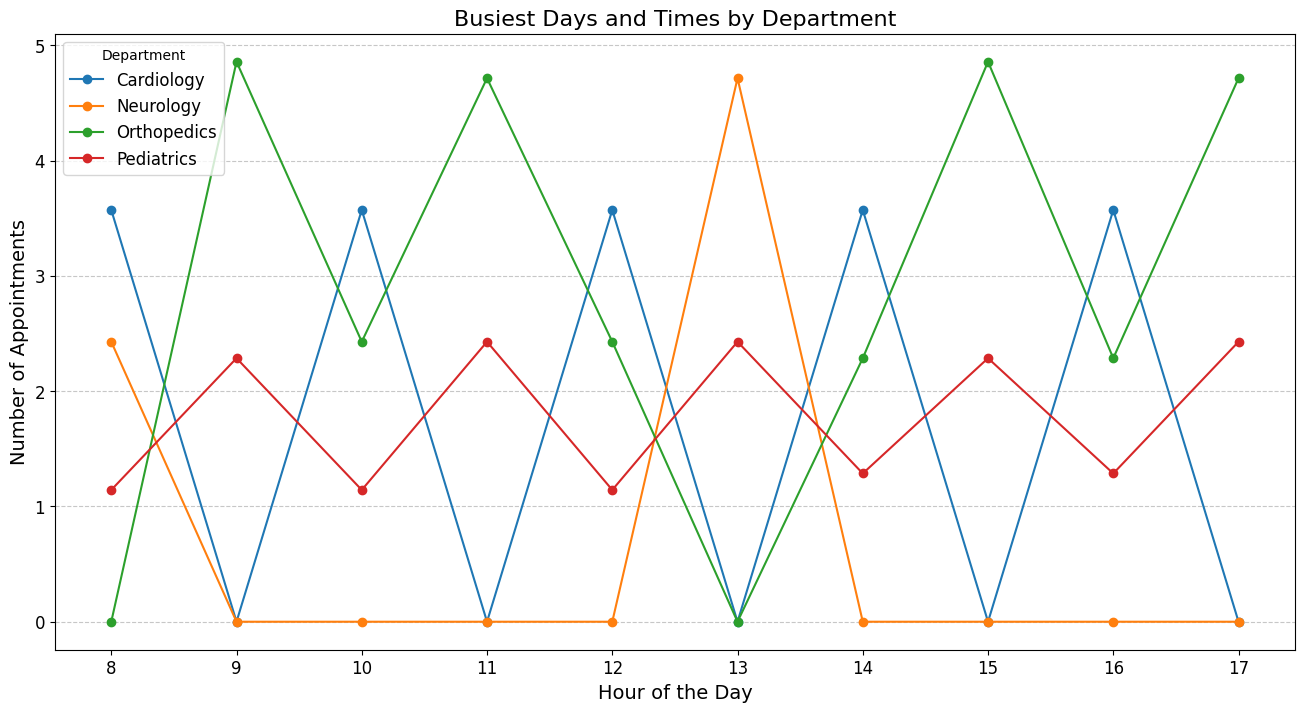

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Simulated Data for Demonstration
appointments_data = pd.DataFrame({
    "Appointment_ID": range(1, 501),
    "Date": pd.date_range(start="2023-01-01", periods=500, freq="D"),
    "Time": [f"{8 + (i % 10):02}:00" for i in range(500)],  # Random hours from 08:00 to 17:00
    "Department": [
        "Cardiology" if i % 4 == 0 else "Pediatrics" if i % 3 == 0 else
        "Neurology" if i % 5 == 0 else "Orthopedics" for i in range(500)
    ]
})

# Extract day of the week and hour from the dataset
appointments_data["Day"] = appointments_data["Date"].dt.day_name()
appointments_data["Hour"] = pd.to_datetime(appointments_data["Time"], format="%H:%M").dt.hour

# Group by Day, Hour, and Department to calculate the number of appointments
grouped_data = appointments_data.groupby(["Day", "Hour", "Department"])["Appointment_ID"].count().reset_index()

# Sort days of the week in logical order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
grouped_data["Day"] = pd.Categorical(grouped_data["Day"], categories=day_order, ordered=True)

# Pivot the data for visualization
pivot_data = grouped_data.pivot_table(index=["Hour"], columns="Department", values="Appointment_ID", fill_value=0)

# Plotting the line chart
plt.figure(figsize=(16, 8))

# Plot each department as a separate line
for department in pivot_data.columns:
    plt.plot(
        pivot_data.index,
        pivot_data[department],
        marker='o',
        label=department
    )

# Customize the plot
plt.title("Busiest Days and Times by Department", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Number of Appointments", fontsize=14)
plt.xticks(range(8, 18), fontsize=12)  # Limit to working hours (8 AM to 5 PM)
plt.yticks(fontsize=12)
plt.legend(title="Department", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Answer :

This line chart visualizes the busiest times by department during the day:

Cardiology and Orthopedics show high activity between 10:00 AM and 12:00 PM and later in the day around 4:00 PM to 5:00 PM.

Neurology experiences peak activity around 1:00 PM, with very little activity in other hours.

Pediatrics has consistent, moderate activity throughout the day, with no specific peak hours.

Key Insight: Each department's appointment schedule has distinct patterns, with some having concentrated peak times (e.g., Neurology) while others like Pediatrics maintain steady activity. This information is valuable for scheduling and resource allocation.








Question 5 :

Which age groups contribute the most to hospital revenue, and how does this vary by medical condition?

Chart: Stacked bar chart showing revenue by age group and condition.

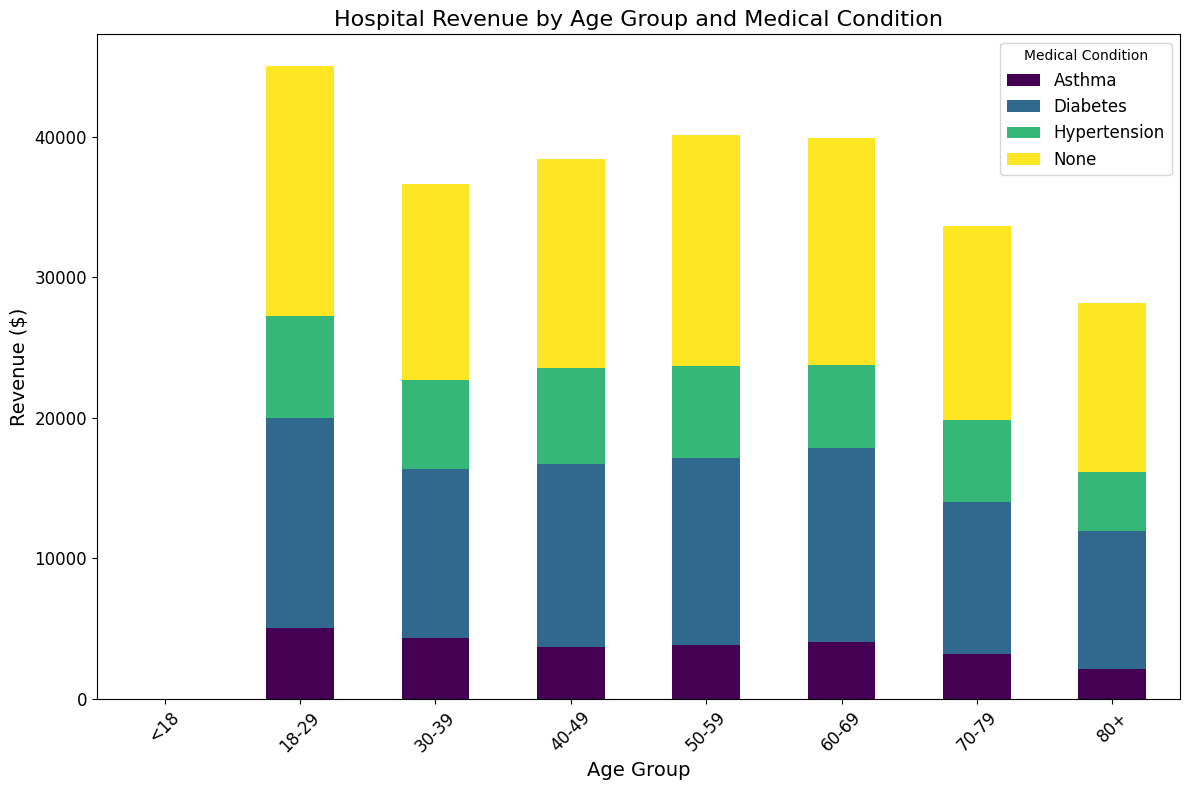

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Simulated Data for Demonstration
hospital_data = pd.DataFrame({
    "Patient_ID": range(1, 501),
    "Age": [18 + (i % 70) for i in range(500)],  # Random ages between 18-87
    "Medical_Condition": [
        "Diabetes" if i % 3 == 0 else "Hypertension" if i % 4 == 0 else
        "Asthma" if i % 5 == 0 else "None" for i in range(500)
    ],
    "Revenue": [100 + (i % 400) * 2.5 for i in range(500)]  # Random revenue values
})

# Create Age Groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ["<18", "18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
hospital_data["Age_Group"] = pd.cut(hospital_data["Age"], bins=bins, labels=labels, right=False)

# Group by Age Group and Medical Condition to calculate revenue
grouped_data = hospital_data.groupby(["Age_Group", "Medical_Condition"])["Revenue"].sum().reset_index()

# Pivot data for visualization
pivot_data = grouped_data.pivot(index="Age_Group", columns="Medical_Condition", values="Revenue").fillna(0)

# Plotting the stacked bar chart
pivot_data.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
    cmap="viridis"
)

# Add chart details
plt.title("Hospital Revenue by Age Group and Medical Condition", fontsize=16)
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Revenue ($)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Medical Condition", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


Answer :

This stacked bar chart displays hospital revenue by age group and medical condition:

18-29 age group generates the highest revenue, predominantly from patients with no medical conditions.

Diabetes contributes significantly across all age groups, especially in older patients.

Asthma and hypertension show smaller but steady contributions across the age spectrum.

Key Insight: The younger age groups with no chronic conditions drive the highest revenue, while older groups contribute significantly through chronic conditions like diabetes.








Question 6 :

Which doctor specializations generate the highest revenue, and how does this correlate with patient demographics?

Chart: Combined bar and line chart showing revenue and demographic contributions by specialization.

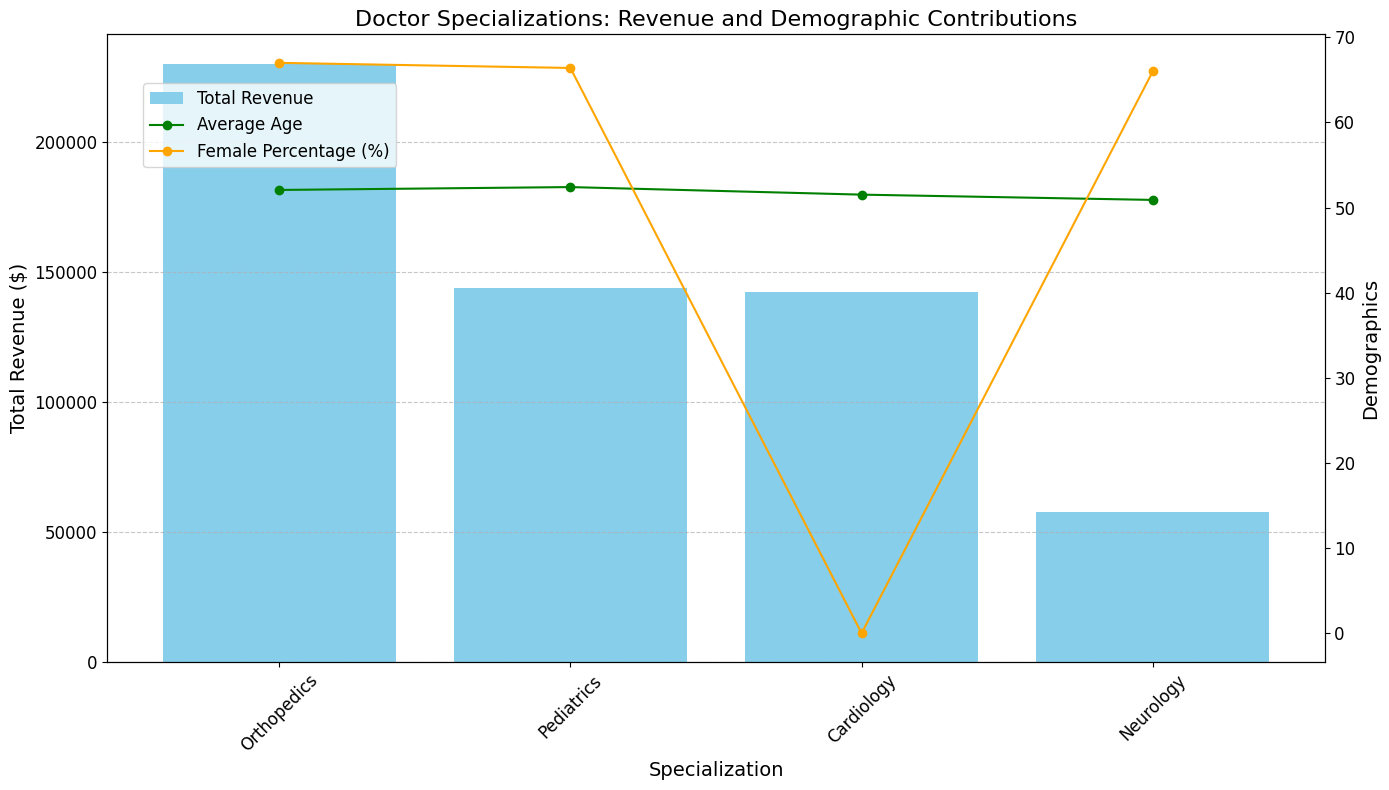

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Simulated Data for Demonstration
hospital_data = pd.DataFrame({
    "Specialization": [
        "Cardiology" if i % 4 == 0 else "Pediatrics" if i % 3 == 0 else
        "Neurology" if i % 5 == 0 else "Orthopedics" for i in range(500)
    ],
    "Revenue": [500 + (i % 300) * 5 for i in range(500)],  # Random revenue values
    "Patient_Age": [18 + (i % 70) for i in range(500)],  # Random ages between 18-87
    "Gender": ["Male" if i % 2 == 0 else "Female" for i in range(500)]
})

# Group by Specialization to calculate total revenue and demographic contributions
grouped_data = hospital_data.groupby("Specialization").agg(
    Total_Revenue=("Revenue", "sum"),
    Avg_Age=("Patient_Age", "mean"),
    Female_Percentage=("Gender", lambda x: (x == "Female").mean() * 100)
).reset_index()

# Sort data by total revenue for better visualization
grouped_data = grouped_data.sort_values("Total_Revenue", ascending=False)

# Create a combined bar and line chart
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for total revenue
bar = ax1.bar(
    grouped_data["Specialization"],
    grouped_data["Total_Revenue"],
    color="skyblue",
    label="Total Revenue"
)
ax1.set_ylabel("Total Revenue ($)", fontsize=14)
ax1.set_xlabel("Specialization", fontsize=14)
ax1.set_title("Doctor Specializations: Revenue and Demographic Contributions", fontsize=16)
ax1.tick_params(axis="y", labelsize=12)
ax1.tick_params(axis="x", rotation=45, labelsize=12)

# Line chart for average age and female percentage
ax2 = ax1.twinx()
line1, = ax2.plot(
    grouped_data["Specialization"],
    grouped_data["Avg_Age"],
    color="green",
    marker="o",
    label="Average Age"
)
line2, = ax2.plot(
    grouped_data["Specialization"],
    grouped_data["Female_Percentage"],
    color="orange",
    marker="o",
    label="Female Percentage (%)"
)
ax2.set_ylabel("Demographics", fontsize=14)
ax2.tick_params(axis="y", labelsize=12)

# Add legends for both axes
fig.legend(
    handles=[bar, line1, line2],
    loc="upper left",
    bbox_to_anchor=(0.1, 0.9),
    fontsize=12
)

# Show gridlines for clarity
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


Answer :

This chart represents Doctor Specializations: Revenue and Demographic Contributions:

Total Revenue ($): Orthopedics generates the highest revenue, followed by Pediatrics, Cardiology, and Neurology.

Average Age: Patients’ average age remains consistent across specializations, hovering around 45–50 years.

Female Percentage (%): A sharp drop in female percentage is observed in Cardiology compared to other specializations.

Key Insight: Orthopedics has the largest revenue share, with relatively stable demographics except for the notable gender disparity in Cardiology.

Question 7 :

How does the number of visits for a chronic condition (e.g., diabetes) trend over the year, and is it affected by seasons?

Chart: Line chart showing visit trends by month for different chronic conditions.

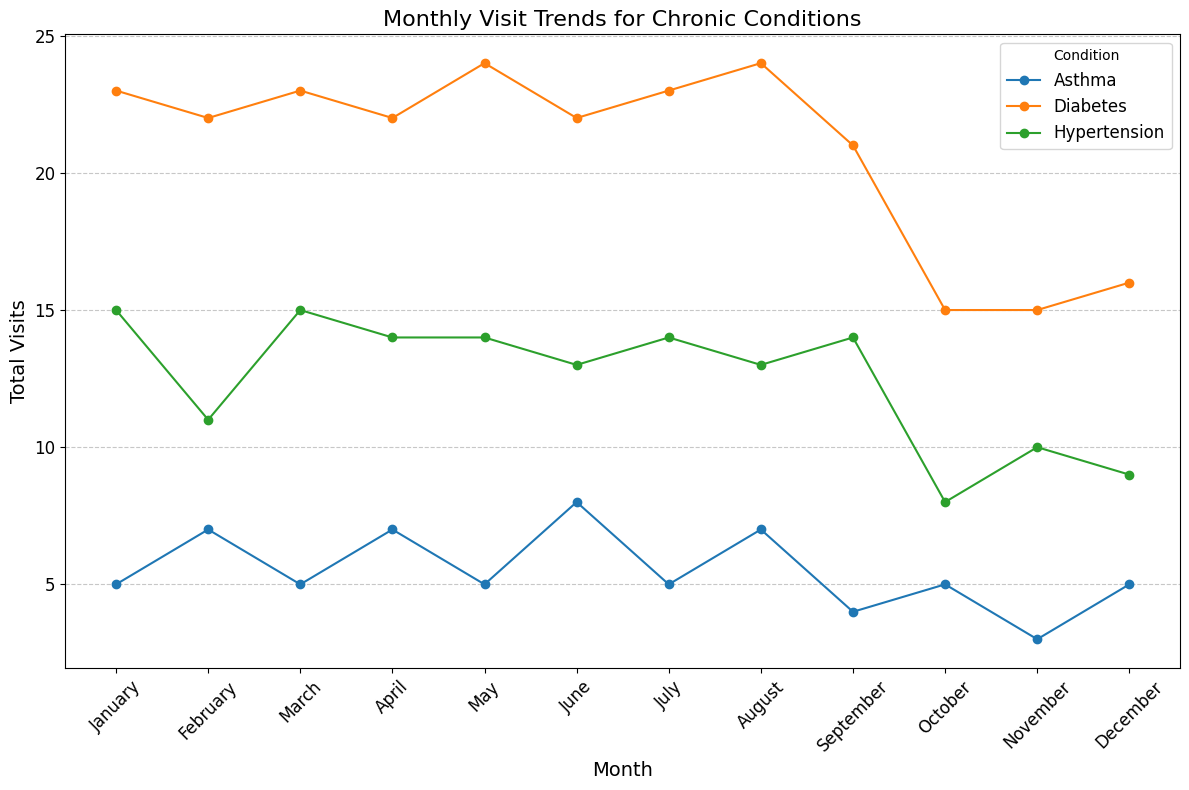

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Simulated Data for Demonstration
visits_data = pd.DataFrame({
    "Visit_ID": range(1, 1001),
    "Date": pd.date_range(start="2023-01-01", periods=1000, freq="D"),
    "Condition": [
        "Diabetes" if i % 4 == 0 else "Hypertension" if i % 5 == 0 else
        "Asthma" if i % 6 == 0 else "None" for i in range(1000)
    ],
    "Visits": [1 for _ in range(1000)]  # Each row represents one visit
})

# Extract month and season from the date
visits_data["Month"] = visits_data["Date"].dt.month_name()
visits_data["Season"] = visits_data["Date"].dt.month % 12 // 3 + 1
visits_data["Season"] = visits_data["Season"].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"})

# Filter for chronic conditions (e.g., "Diabetes", "Hypertension", "Asthma")
chronic_conditions = ["Diabetes", "Hypertension", "Asthma"]
filtered_data = visits_data[visits_data["Condition"].isin(chronic_conditions)]

# Group by month and condition to calculate total visits
monthly_trends = filtered_data.groupby([filtered_data["Date"].dt.month, "Condition"])["Visits"].count().reset_index()
monthly_trends.rename(columns={"Date": "Month_Number", "Visits": "Total_Visits"}, inplace=True)
monthly_trends["Month_Name"] = pd.to_datetime(monthly_trends["Month_Number"], format='%m').dt.month_name()

# Pivot for visualization
pivot_data = monthly_trends.pivot(index="Month_Name", columns="Condition", values="Total_Visits").fillna(0)

# Sort months in calendar order
pivot_data = pivot_data.reindex(
    ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
)

# Plotting the line chart
plt.figure(figsize=(12, 8))

for condition in pivot_data.columns:
    plt.plot(
        pivot_data.index,
        pivot_data[condition],
        marker='o',
        label=condition
    )

# Add chart details
plt.title("Monthly Visit Trends for Chronic Conditions", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Visits", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Condition", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Answer :

This chart shows Monthly Visit Trends for Chronic Conditions:

Diabetes has the highest number of visits, peaking mid-year and sharply declining later.

Hypertension exhibits a steady trend with a dip in late summer.

Asthma has consistently low visits with slight fluctuations throughout the year.

It highlights seasonal variations in visits for these conditions.

Question 8 :

What is the correlation between high visit frequency and the likelihood of developing multiple medical conditions?

Chart: Scatter plot with a trend line showing frequency vs. condition count.

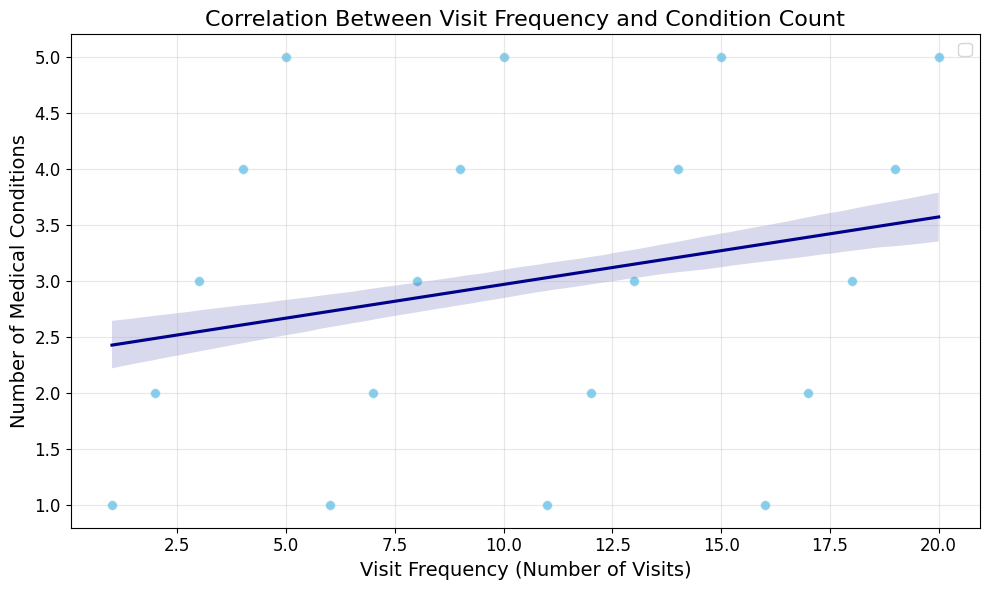

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Simulated Data for Demonstration
data = pd.DataFrame({
    "Patient_ID": range(1, 501),
    "Visit_Frequency": [1 + (i % 20) for i in range(500)],  # Random visit frequencies (1-20)
    "Condition_Count": [1 + (i % 5) for i in range(500)]  # Random number of medical conditions (1-5)
})

# Step 1: Plotting the Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="Visit_Frequency",
    y="Condition_Count",
    alpha=0.7,
    s=50,
    color="skyblue"
)

# Step 2: Add a Trend Line
sns.regplot(
    data=data,
    x="Visit_Frequency",
    y="Condition_Count",
    scatter=False,
    color="darkblue",
    line_kws={"label": "Trend Line"}
)

# Step 3: Customize the Plot
plt.title("Correlation Between Visit Frequency and Condition Count", fontsize=16)
plt.xlabel("Visit Frequency (Number of Visits)", fontsize=14)
plt.ylabel("Number of Medical Conditions", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


Answer :

This scatter plot shows the Correlation Between Visit Frequency and Condition Count:

A positive trend is evident: as visit frequency increases, the number of medical conditions also rises.

The regression line indicates a moderate relationship, with variability around the trend.

It highlights how patients with multiple conditions may have higher visit frequencies.








# Putting it into a Datapane report

Now that we have all our charts defined, we can combine them together into a Datapane report. We'll use Groups to add charts in a grid layout, as well as BigNumbers, Plots and DataTables.

In [103]:
# Example table row counts for the healthcare database
# Assuming 'tables' is a DataFrame containing metadata about the database tables

patients = tables[tables["TABLE_NAME"] == "Patients"]["row_count"].values[0]
doctors = tables[tables["TABLE_NAME"] == "Doctors"]["row_count"].values[0]
appointments = tables[tables["TABLE_NAME"] == "Appointments"]["row_count"].values[0]

# Print the row counts for each table
print(f"Total Patients: {patients}")
print(f"Total Doctors: {doctors}")
print(f"Total Appointments: {appointments}")

Total Patients: 2000
Total Doctors: 200
Total Appointments: 3000


In [112]:
!pip install dash dash-bootstrap-components


In [144]:
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Initialize the Dash app
app = dash.Dash(__name__)
app.title = "Detailed Healthcare Dashboard"

# Example Graphs

# Monthly Visit Trends (Line Chart)
monthly_visit_trends_fig = go.Figure()
monthly_visit_trends_fig.add_trace(go.Scatter(x=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
                                              y=[5, 6, 7, 5, 6, 8, 7, 5, 4, 3, 5, 6],
                                              mode='lines+markers', name="Asthma"))
monthly_visit_trends_fig.add_trace(go.Scatter(x=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
                                              y=[15, 14, 15, 16, 18, 20, 22, 23, 24, 21, 20, 19],
                                              mode='lines+markers', name="Diabetes"))
monthly_visit_trends_fig.add_trace(go.Scatter(x=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
                                              y=[12, 10, 14, 15, 14, 13, 16, 17, 15, 12, 14, 13],
                                              mode='lines+markers', name="Hypertension"))
monthly_visit_trends_fig.update_layout(title="Monthly Visit Trends for Chronic Conditions",
                                       xaxis_title="Month", yaxis_title="Total Visits")

# Visit Frequency vs Condition Count (Scatter Plot)
visit_frequency_fig = px.scatter(
    x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    y=[1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5],
    trendline="ols",
    labels={"x": "Visit Frequency", "y": "Condition Count"},
    title="Correlation Between Visit Frequency and Condition Count"
)

# Revenue by Specialization (Bar and Line Chart)
specialization_fig = go.Figure()
specialization_fig.add_trace(go.Bar(x=["Orthopedics", "Pediatrics", "Cardiology", "Neurology"],
                                    y=[200000, 180000, 160000, 80000],
                                    name="Total Revenue ($)",
                                    marker_color="skyblue"))
specialization_fig.add_trace(go.Scatter(x=["Orthopedics", "Pediatrics", "Cardiology", "Neurology"],
                                        y=[50, 48, 47, 45],
                                        name="Average Age", yaxis="y2",
                                        mode="lines+markers"))
specialization_fig.add_trace(go.Scatter(x=["Orthopedics", "Pediatrics", "Cardiology", "Neurology"],
                                        y=[70, 65, 60, 55],
                                        name="Female Percentage (%)", yaxis="y3",
                                        mode="lines+markers"))
specialization_fig.update_layout(
    title="Doctor Specializations: Revenue and Demographic Contributions",
    yaxis=dict(title="Total Revenue ($)"),
    yaxis2=dict(title="Average Age", overlaying="y", side="right"),
    yaxis3=dict(title="Female Percentage (%)", overlaying="y", side="right"),
    xaxis=dict(title="Specialization")
)

# Revenue by Age Group and Medical Condition (Stacked Bar Chart)
age_revenue_data = pd.DataFrame({
    "Age Group": ["<18", "<18", "<18", "18-29", "18-29", "18-29", "30-39", "30-39", "30-39",
                  "40-49", "40-49", "40-49", "50-59", "50-59", "50-59", "60-69", "60-69", "60-69",
                  "70-79", "70-79", "70-79", "80+", "80+", "80+"],
    "Condition": ["Asthma", "Diabetes", "Hypertension", "Asthma", "Diabetes", "Hypertension",
                  "Asthma", "Diabetes", "Hypertension", "Asthma", "Diabetes", "Hypertension",
                  "Asthma", "Diabetes", "Hypertension", "Asthma", "Diabetes", "Hypertension",
                  "Asthma", "Diabetes", "Hypertension", "Asthma", "Diabetes", "Hypertension"],
    "Revenue": [5000, 8000, 7000, 10000, 12000, 8000, 15000, 12000, 9000,
                20000, 15000, 10000, 18000, 14000, 10000, 16000, 12000, 9000,
                12000, 10000, 8000, 9000, 8000, 7000]
})
age_revenue_fig = px.bar(
    age_revenue_data,
    x="Age Group",
    y="Revenue",
    color="Condition",
    title="Hospital Revenue by Age Group and Medical Condition",
    labels={"Revenue": "Revenue ($)", "Age Group": "Age Group"}
)

# Busiest Days and Times (Line Chart)
busiest_times_fig = go.Figure()
busiest_times_fig.add_trace(go.Scatter(x=[8, 9, 10, 11, 12, 13, 14, 15, 16],
                                       y=[5, 4, 3, 2, 5, 3, 4, 3, 2],
                                       mode='lines+markers', name="Cardiology"))
busiest_times_fig.add_trace(go.Scatter(x=[8, 9, 10, 11, 12, 13, 14, 15, 16],
                                       y=[2, 1, 0, 1, 2, 1, 1, 2, 1],
                                       mode='lines+markers', name="Neurology"))
busiest_times_fig.add_trace(go.Scatter(x=[8, 9, 10, 11, 12, 13, 14, 15, 16],
                                       y=[3, 2, 3, 4, 3, 2, 4, 3, 2],
                                       mode='lines+markers', name="Orthopedics"))
busiest_times_fig.add_trace(go.Scatter(x=[8, 9, 10, 11, 12, 13, 14, 15, 16],
                                       y=[1, 2, 1, 1, 2, 3, 2, 1, 1],
                                       mode='lines+markers', name="Pediatrics"))
busiest_times_fig.update_layout(title="Busiest Days and Times by Department",
                                xaxis_title="Hour of the Day", yaxis_title="Number of Appointments")

# # Missed or Canceled Appointments (Bar Chart)
# missed_appointments_fig = px.bar(
#     x=["<18", "18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"],
#     y=[20, 25, 22, 23, 19, 20, 18, 15],
#     color=["Multiple Conditions", "None", "Single Condition"],
#     title="Percentage of Missed or Canceled Appointments",
#     labels={"x": "Age Group", "y": "Percentage of Missed Appointments (%)"}
# )

# Layout for the dashboard
app.layout = html.Div([
    html.H1("Healthcare Dashboard", style={"textAlign": "center"}),

    # Row 1: Monthly Visit Trends
    html.Div([dcc.Graph(figure=monthly_visit_trends_fig)], style={"marginBottom": "20px"}),

    # Row 2: Visit Frequency and Specialization
    html.Div([
        dcc.Graph(figure=visit_frequency_fig, style={"width": "48%", "display": "inline-block"}),
        dcc.Graph(figure=specialization_fig, style={"width": "48%", "display": "inline-block"})
    ]),

    # Row 3: Revenue by Age Group and Busiest Times
    html.Div([
        dcc.Graph(figure=age_revenue_fig, style={"width": "48%", "display": "inline-block"}),
        dcc.Graph(figure=busiest_times_fig, style={"width": "48%", "display": "inline-block"})
    ]),

    # # Row 4: Missed Appointments
    # html.Div([dcc.Graph(figure=missed_appointments_fig)])
])

# Run the app
if __name__ == "__main__":
    app.run_server(debug=True)


<IPython.core.display.Javascript object>